In [1]:
import random
import pylab
import numpy as np
import copy

import tensorflow as tf
from tensorboardX import SummaryWriter
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K

In [2]:
import gym
#Custom environments
import gym_LunarLanderTerrainNoData
import gym_LunarLanderTerrainHeight
import gym_LunarLanderTerrainData
import gym_LunarLanderRoughTerrain

In [3]:
class actor_model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        self.action_space = action_space

        X = Dense(512, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X_input)
        X = Dense(256, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X)
        X = Dense(64, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X)
        output = Dense(self.action_space, activation="softmax")(X)

        self.actor = Model(inputs = X_input, outputs = output)
        self.actor.compile(loss=self.ppo_loss, optimizer=optimizer(lr=lr))
    
    #Loss function
    def ppo_loss(self, y_true, y_pred):
        advantages, prediction_picks, actions = y_true[:, :1], y_true[:, 1:1+self.action_space], y_true[:, 1+self.action_space:]
        LOSS_CLIPPING = 0.2
        ENTROPY_LOSS = 0.001
        
        prob = actions * y_pred
        old_prob = actions * prediction_picks
        
        prob = K.clip(prob, 1e-10, 1.0)
        old_prob = K.clip(old_prob, 1e-10, 1.0)
        
        ratio = K.exp(K.log(prob) - K.log(old_prob))
        
        p1 = ratio * advantages
        p2 = K.clip(ratio, min_value = 1 - LOSS_CLIPPING, max_value = 1 + LOSS_CLIPPING) * advantages
        
        actor_loss = -K.mean(K.minimum(p1, p2))
        
        entropy = -(y_pred * K.log(y_pred + 1e-10))
        entropy = ENTROPY_LOSS * K.mean(entropy)
        
        total_loss = actor_loss - entropy
        
        return total_loss
    
    def predict(self, state):
        return self.actor.predict(state)

In [4]:
class critic_model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        old_values = Input(shape=(1,))
        
        X = Dense(512, activation="relu", kernel_initializer="he_uniform")(X_input)
        X = Dense(256, activation="relu", kernel_initializer="he_uniform")(X)
        X = Dense(64, activation="relu", kernel_initializer="he_uniform")(X)
        value = Dense(1, activation=None)(X)
        
        self.critic = Model(inputs=[X_input, old_values], outputs = value)
        self.critic.compile(loss=[self.critic_PPO2_loss(old_values)], optimizer=optimizer(lr=lr))
    
    #Loss function
    def critic_PPO2_loss(self, values):
        def loss(y_true, y_pred):
            LOSS_CLIPPING = 0.2
            clipped_value_loss = values + K.clip(y_pred - values, -LOSS_CLIPPING, LOSS_CLIPPING)
            v_loss1 = (y_true - clipped_value_loss) ** 2
            v_loss2 = (y_true - y_pred) ** 2
            
            value_loss = 0.5 * K.mean(K.maximum(v_loss1, v_loss2))
            return value_loss
        return loss
    
    def predict(self, state):
        return self.critic.predict([state, np.zeros((state.shape[0], 1))])

In [5]:
class model:
    def __init__(self, env_name):
        # Initialization
        # Environment and PPO parameters
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.action_size = self.env.action_space.n
        self.state_size = self.env.observation_space.shape
        self.EPISODES = 10000 # total episodes to train through all environments
        self.episode = 0 # used to track the episodes total count of episodes played through all thread environments
        self.max_average = 0 # when average score is above 0 model will be saved
        self.lr = 0.00025
        self.epochs = 10 # training epochs
        self.shuffle=False
        self.training_batch = 1000
        self.optimizer = Adam

        self.replay_count = 0
        self.writer = SummaryWriter(comment="_"+self.env_name+"_"+self.optimizer.__name__+"_"+str(self.lr))
        
        # Instantiate plot memory
        self.scores_, self.episodes_, self.average_ = [], [], [] # used in matplotlib plots

        # Create Actor-Critic network models
        self.actor = actor_model(input_shape=self.state_size, action_space = self.action_size, lr=self.lr, optimizer = self.optimizer)
        self.critic = critic_model(input_shape=self.state_size, action_space = self.action_size, lr=self.lr, optimizer = self.optimizer)
        
        self.name = f"{self.env_name}_PPO"
        
    def act(self, state):
        #predict the next action to take, using the model
        prediction = self.actor.predict(state)[0]
        action = np.random.choice(self.action_size, p=prediction)
        action_onehot = np.zeros([self.action_size])
        action_onehot[action] = 1
        return action, action_onehot, prediction
    
    #Generalized Advantage Estimation
    def get_gaes(self, rewards, dones, values, next_values, gamma = 0.99, lamda = 0.9, normalize = True):
        deltas = [r + gamma * (1-d) * nv - v for r, d, nv, v in zip(rewards, dones, next_values, values)]
        deltas = np.stack(deltas)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(deltas)-1)):
            gaes[t] = gaes[t] + (1 - dones[t]) * gamma * lamda * gaes[t+1]

        target = gaes + values
        if normalize:
            gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
        return np.vstack(gaes), np.vstack(target)
    
    def replay(self, states, actions, rewards, predictions, dones, next_states):
        #Reshape memory to approproate shape for training
        states = np.vstack(states)
        next_states = np.vstack(next_states)
        actions = np.vstack(actions)
        predictions = np.vstack(predictions)

        #Get Critic network predictions
        values = self.critic.predict(states)
        next_values = self.critic.predict(next_states)

        #Compute discounted rewards and advantages
        advantages, target = self.get_gaes(rewards, dones, np.squeeze(values), np.squeeze(next_values))

        #Stack everything to numpy array
        #Pack all advantags, predictions, and action to y_true and when they are received in custom PPO loss function we unpack it
        y_true = np.hstack([advantages, predictions, actions])

        #Training actor and critic networks
        a_loss = self.actor.actor.fit(states, y_true, epochs=self.epochs, verbose=0, shuffle=self.shuffle)
        c_loss = self.critic.critic.fit([states, values], target, epochs=self.epochs, verbose=0, shuffle=self.shuffle)
    
    #Save weights to file
    def save(self, name):
        self.actor.actor.save_weights(name+"_Actor.h5")
        self.critic.critic.save_weights(name+"_Critic.h5")
    
    #Load weights from file
    def load(self, actor_weights_name, critic_weights_name):
        self.actor.actor.load_weights(actor_weights_name)
        self.critic.critic.load_weights(critic_weights_name)
    
    #Save the model when it performs the best
    def save_best(self, score, episode):
        self.scores_.append(score)
        self.episodes_.append(episode)
        self.average_.append(sum(self.scores_[-50:]) / len(self.scores_[-50:]))
        
        #Save and plot every 100 episodes
        if str(episode)[-2:] == "00":
            self.save(self.name+"_Episode"+str(episode))
            
            pylab.plot(self.episodes_, self.scores_, 'b')
            pylab.plot(self.episodes_, self.average_, 'r')
            pylab.title(self.env_name+" PPO training cycle", fontsize=18)
            pylab.ylabel('Score', fontsize=18)
            pylab.xlabel('Steps', fontsize=18)
            try:
                pylab.grid(True)
                pylab.savefig(self.env_name+".png")
            except OSError:
                pass
        
        #Save best models
        if self.average_[-1] >= self.max_average:
            self.max_average = self.average_[-1]
            
            self.save(self.name)
            SAVING = "SAVING"
            
            #Learning rate decay
            self.lr *= 0.95
            K.set_value(self.actor.actor.optimizer.learning_rate, self.lr)
            K.set_value(self.critic.critic.optimizer.learning_rate, self.lr)
        else:
            SAVING = ""
        
        return self.average_[-1], SAVING
    
    #Train the model
    def run_batch(self):
        state = self.env.reset()
        state = np.reshape(state, [1, self.state_size[0]])
        done, score, SAVING, = False, 0, ''

        while True:
            #Initialize or reset memory
            states, next_states, actions, rewards, predictions, dones = [], [], [], [], [], []
            for t in range(self.training_batch):
                #self.env.render()
                action, action_onehot, prediction = self.act(state)
                next_state, reward, done, _ = self.env.step(action)

                states.append(state)
                next_states.append(np.reshape(next_state, [1, self.state_size[0]]))
                actions.append(action_onehot)
                rewards.append(reward)
                dones.append(done)
                predictions.append(prediction)

                state = np.reshape(next_state, [1, self.state_size[0]])
                score += reward

                if done:
                    self.episode += 1
                    average, SAVING = self.save_best(score, self.episode)
                    print("episode: {}/{}, score: {}, average: {:.2f} {}".format(self.episode, self.EPISODES, score, average, SAVING))

                    state, done, score, SAVING = self.env.reset(), False, 0, ''
                    state = np.reshape(state, [1, self.state_size[0]])

            self.replay(states, actions, rewards, predictions, dones, next_states)
    
    #Run the model
    def run(self, num):
        for i in range(num):
            state = self.env.reset()
            state=np.reshape(state, [1, self.state_size[0]])
            done = False
            score = 0
            
            for t in range(1000):
                self.env.render()
                action = np.argmax(self.actor.predict(state)[0])
                state, reward, done, _ = self.env.step(action)
                state = np.reshape(state, [1, self.state_size[0]])
                score += reward

                if done:
                    break
            
            print("Score:", score)
                    
        self.env.close()

In [23]:
#env_name = "LunarLanderTerrainNoData-v0"
#env_name = "LunarLanderRoughTerrainHeight-v0"
env_name = "LunarLanderTerrainData-v0"
#env_name = "LunarLanderTerrainHeight-v1"

episode: 1/10000, score: -144.75114569924938, average: -144.75 
episode: 2/10000, score: -101.04319562450462, average: -122.90 
episode: 3/10000, score: -340.3057231810597, average: -195.37 
episode: 4/10000, score: -159.5211494338884, average: -186.41 
episode: 5/10000, score: -210.76329464674464, average: -191.28 
episode: 6/10000, score: -169.83615747658848, average: -187.70 
episode: 7/10000, score: -353.0732515597721, average: -211.33 
episode: 8/10000, score: -306.9862966786953, average: -223.29 
episode: 9/10000, score: -161.5447824859942, average: -216.42 
episode: 10/10000, score: -101.4302312944862, average: -204.93 
episode: 11/10000, score: -377.02106925660246, average: -220.57 
episode: 12/10000, score: -205.45591057607743, average: -219.31 
episode: 13/10000, score: -183.0863215524446, average: -216.52 
episode: 14/10000, score: -97.13474427919695, average: -208.00 
episode: 15/10000, score: -116.71845786950544, average: -201.91 
episode: 16/10000, score: -237.12040525659

Exception ignored in: <function Viewer.__del__ at 0x000001EB3D451C10>
Traceback (most recent call last):
  File "c:\users\dennis\appdata\local\programs\python\python38\lib\site-packages\gym\envs\classic_control\rendering.py", line 165, in __del__
    self.close()
  File "c:\users\dennis\appdata\local\programs\python\python38\lib\site-packages\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "c:\users\dennis\appdata\local\programs\python\python38\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "c:\users\dennis\appdata\local\programs\python\python38\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "c:\users\dennis\appdata\local\programs\python\python38\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x000001EB4CBA4860; to 'Win32Window' at 0x000001EB3CFCC610>


episode: 100/10000, score: -198.91857045382352, average: -188.55 
episode: 101/10000, score: -140.47135747209893, average: -188.76 
episode: 102/10000, score: -164.8807596102376, average: -189.61 
episode: 103/10000, score: -165.06185837183915, average: -182.50 
episode: 104/10000, score: -89.80474078820617, average: -179.68 
episode: 105/10000, score: -168.59483676521813, average: -173.05 
episode: 106/10000, score: -113.35146801200258, average: -169.33 
episode: 107/10000, score: -159.50723568466063, average: -163.59 
episode: 108/10000, score: -82.00272826919954, average: -161.80 
episode: 109/10000, score: -123.86863342705777, average: -160.52 
episode: 110/10000, score: -75.71474749936735, average: -158.17 
episode: 111/10000, score: -96.20516440108236, average: -157.99 
episode: 112/10000, score: -229.67608008400498, average: -159.57 
episode: 113/10000, score: -114.08041973208032, average: -159.73 
episode: 114/10000, score: -303.58192997483934, average: -159.52 
episode: 115/10

KeyboardInterrupt: 

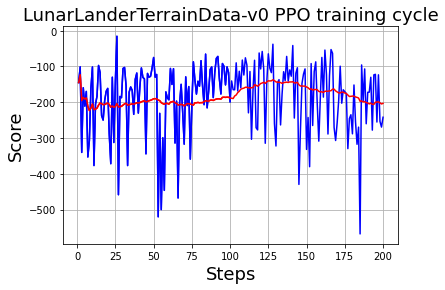

In [24]:
#TRAIN MODEL ()
agent = model(env_name)
agent.run_batch()

In [25]:
#RUN TRAINED MODEL
agent.run(10)

AssertionError: IsLocked() == false

In [14]:
#LOAD AND RUN MODEL
#The actor is given its height above the terrain
#The terrain is rougher
env_name = "LunarLanderRoughTerrain-v0"
#env_name = "LunarLanderTerrainHeight-v1"
actor_weights="TRAINED_LunarLanderRoughTerrain-v0_PPO_Actor.h5"
critic_weights="TRAINED_LunarLanderRoughTerrain-v0_PPO_Critic.h5"

agent = model(env_name)
agent.load(actor_weights, critic_weights)

agent.run(5)

Score: 297.6994813610168
Score: 291.37684248169575
Score: 348.9621708976749
Score: 197.1476398452467
Score: 310.08765451946977


In [11]:
#LOAD AND RUN MODEL
#The actor is given its height above the terrain
env_name = "LunarLanderTerrainHeight-v1"
actor_weights="TRAINED_LunarLanderTerrainHeight-v1_PPO_Actor.h5"
critic_weights="TRAINED_LunarLanderTerrainHeight-v1_PPO_Critic.h5"

agent = model(env_name)
agent.load(actor_weights, critic_weights)

agent.run(5)

Score: 139.66730095891538
Score: 330.2483108307755
Score: 61.08357361557893
Score: 396.6500414902498
Score: 294.4326733675938


In [12]:
#LOAD AND RUN MODEL
#The actor is not given any information about the terrain
env_name = "LunarLanderTerrainNoData-v0"
actor_weights="TRAINED_LunarLanderTerrainNoData-v0_PPO_Actor.h5"
critic_weights="TRAINED_LunarLanderTerrainNoData-v0_PPO_Critic.h5"

agent = model(env_name)
agent.load(actor_weights, critic_weights)

agent.run(5)

Score: 263.69309931960214
Score: 237.58075325880287
Score: 264.7546009568011
Score: 280.10304180476305
Score: 202.5956027062516


In [13]:
#LOAD AND RUN MODEL
#The actor is given the average slope of each chunk of terrain
env_name = "LunarLanderTerrainData-v0"
actor_weights="LunarLanderTerrainData-v0_PPO_Actor.h5"
critic_weights="LunarLanderTerrainData-v0_PPO_Critic.h5"

agent = model(env_name)
agent.load(actor_weights, critic_weights)

agent.run(5)

Score: 129.3921712420662
Score: 168.29774658840046
Score: 124.61381483500803
Score: 174.6677774819201
Score: -101.2361470616498


In [ ]:
#Do random actions (for comparison)

env = gym.make("LunarLanderRoughTerrain-v0")
def random_games():
    for episode in range(10):
        observation = env.reset()
        while True:
            env.render()
            
            action = env.action_space.sample()
            next_state, reward, done, info = env.step(action)
            
            if done:
                break

random_games()
env.close()